In [1]:
!pip install numpy torch scikit-learn pandas matplotlib seaborn

In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn
!pip install tensorflow xgboost imbalanced-learn

In [3]:
# Install required packages
!pip install pandas numpy scikit-learn matplotlib seaborn
!pip install tensorflow xgboost imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

import joblib
from datetime import datetime
import time

In [4]:
# Note: Download CIC-IDS2017 dataset from:
# https://www.unb.ca/cic/datasets/ids-2017.html
# For demonstration, we'll create a sample dataset with realistic features

# Create sample cybersecurity dataset
np.random.seed(42)
n_samples = 10000

# Generate synthetic network traffic data
data = {
    'flow_duration': np.random.exponential(1000, n_samples),
    'total_fwd_packets': np.random.poisson(50, n_samples),
    'total_backward_packets': np.random.poisson(30, n_samples),
    'total_length_fwd_packets': np.random.gamma(2, 500, n_samples),
    'total_length_bwd_packets': np.random.gamma(2, 300, n_samples),
    'fwd_packet_length_max': np.random.gamma(2, 100, n_samples),
    'fwd_packet_length_min': np.random.exponential(10, n_samples),
    'fwd_packet_length_mean': np.random.normal(50, 20, n_samples),
    'bwd_packet_length_max': np.random.gamma(2, 80, n_samples),
    'bwd_packet_length_min': np.random.exponential(8, n_samples),
    'flow_bytes_s': np.random.gamma(2, 1000, n_samples),
    'flow_packets_s': np.random.gamma(2, 10, n_samples),
    'flow_iat_mean': np.random.exponential(100, n_samples),
    'flow_iat_std': np.random.exponential(50, n_samples),
    'flow_iat_max': np.random.gamma(2, 200, n_samples),
    'flow_iat_min': np.random.exponential(5, n_samples),
    'fwd_iat_total': np.random.gamma(2, 500, n_samples),
    'fwd_iat_mean': np.random.exponential(100, n_samples),
    'bwd_iat_total': np.random.gamma(2, 300, n_samples),
    'bwd_iat_mean': np.random.exponential(80, n_samples),
}

# Create realistic attack patterns
labels = []
for i in range(n_samples):
    # Normal traffic (70%)
    if i < n_samples * 0.7:
        labels.append('BENIGN')
    # DDoS attacks (10%)
    elif i < n_samples * 0.8:
        labels.append('DDoS')
        # Modify features for DDoS pattern
        data['total_fwd_packets'][i] *= 10
        data['flow_packets_s'][i] *= 20
    # Port Scan (8%)
    elif i < n_samples * 0.88:
        labels.append('PortScan')
        data['flow_duration'][i] /= 10
        data['total_fwd_packets'][i] = 1
    # Brute Force (7%)
    elif i < n_samples * 0.95:
        labels.append('BruteForce')
        data['flow_iat_mean'][i] /= 100
    # Web Attack (5%)
    else:
        labels.append('WebAttack')
        data['total_length_fwd_packets'][i] *= 5

data['label'] = labels
df = pd.DataFrame(data)

print("Dataset Shape:", df.shape)
print("\nLabel Distribution:")
print(df['label'].value_counts())

# Display first few rows
df.head()

Dataset Shape: (10000, 21)

Label Distribution:
label
BENIGN        7000
DDoS          1000
PortScan       800
BruteForce     700
WebAttack      500
Name: count, dtype: int64


,flow_duration,total_fwd_packets,total_backward_packets,total_length_fwd_packets,total_length_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,bwd_packet_length_max,bwd_packet_length_min,flow_bytes_s,flow_packets_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,bwd_iat_total,bwd_iat_mean,label
0,469.268090,47,34,637.119671,554.252235,536.868621,10.370568,54.295019,309.970479,3.488410,2818.884527,10.626019,75.658550,15.105871,324.582245,2.025994,2176.420052,8.538226,1464.974653,3.021326,BENIGN
1,3010.121431,42,42,532.845928,813.494521,143.123827,2.770692,42.243721,93.645153,7.549159,4192.265975,26.774944,108.518685,7.093638,425.515606,2.527577,1183.663973,24.629808,236.317203,15.975544,BENIGN
2,1316.745694,49,24,1162.106736,210.963888,121.097591,1.398959,25.240281,251.701752,14.113622,4489.203110,21.268679,111.295145,49.918175,353.920644,0.661883,2484.446730,27.083261,1598.704808,51.198451,BENIGN
3,912.942554,56,37,1325.986609,152.823785,15.606180,6.860226,29.343932,213.885384,27.552834,487.257928,9.412436,139.021558,12.743806,627.027363,19.520550,571.730992,158.503611,1302.028424,3.815219,BENIGN
4,169.624870,60,36,1372.088331,1095.866469,123.634935,13.896282,39.263811,20.732732,8.089678,2398.547835,10.863890,236.245518,2.183960,729.292409,9.342316,809.394176,134.015059,1234.348036,52.599489,BENIGN


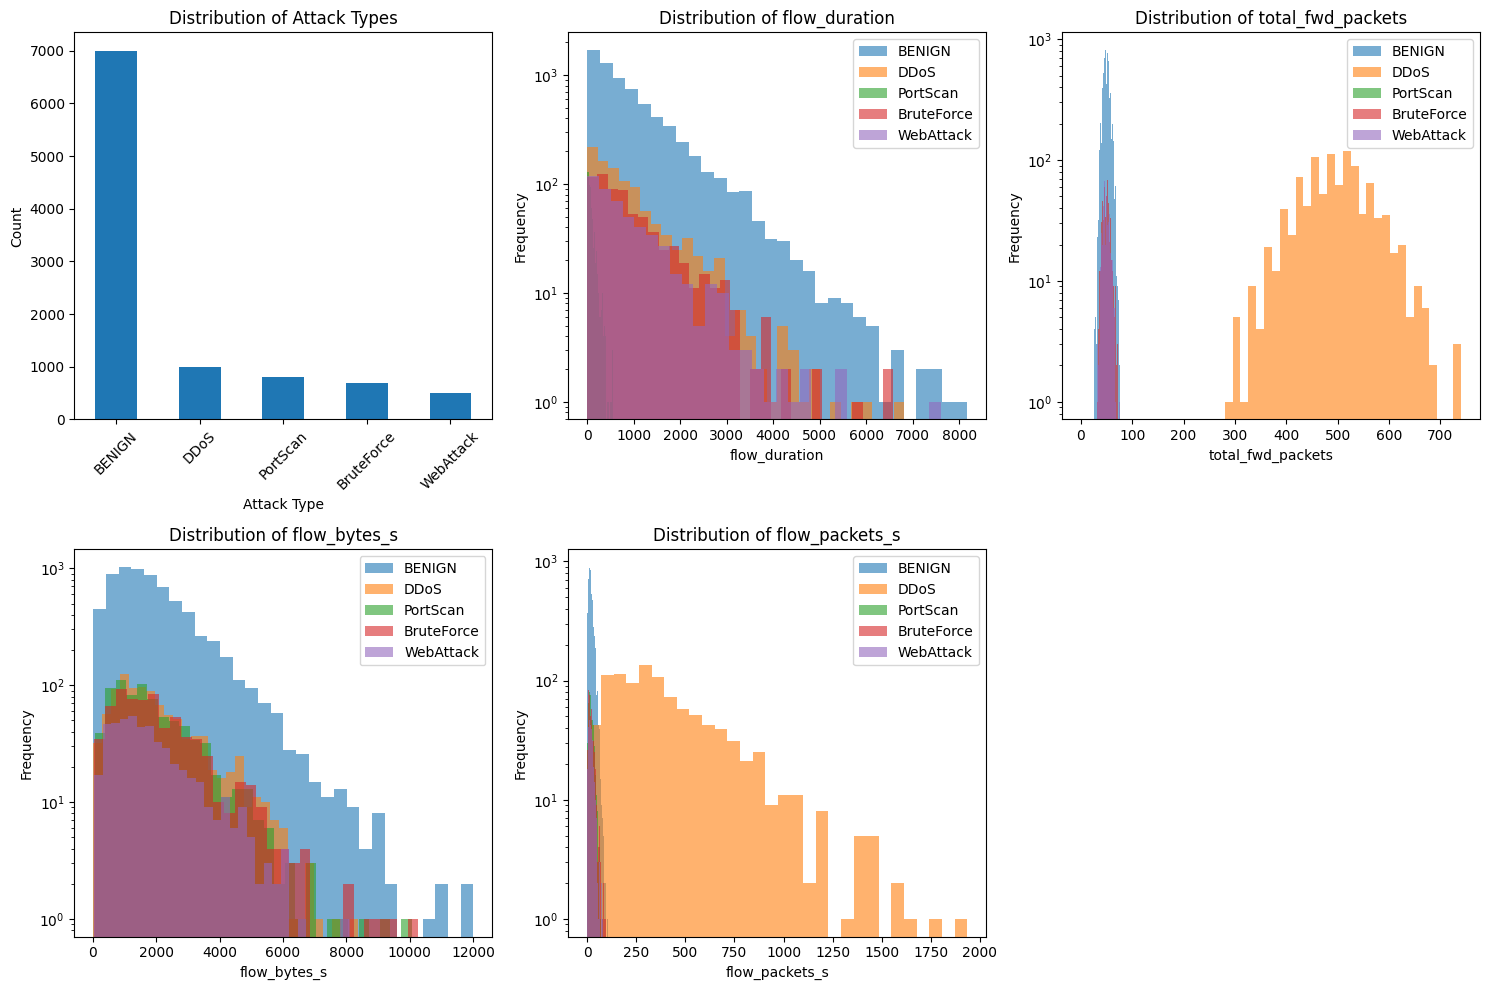

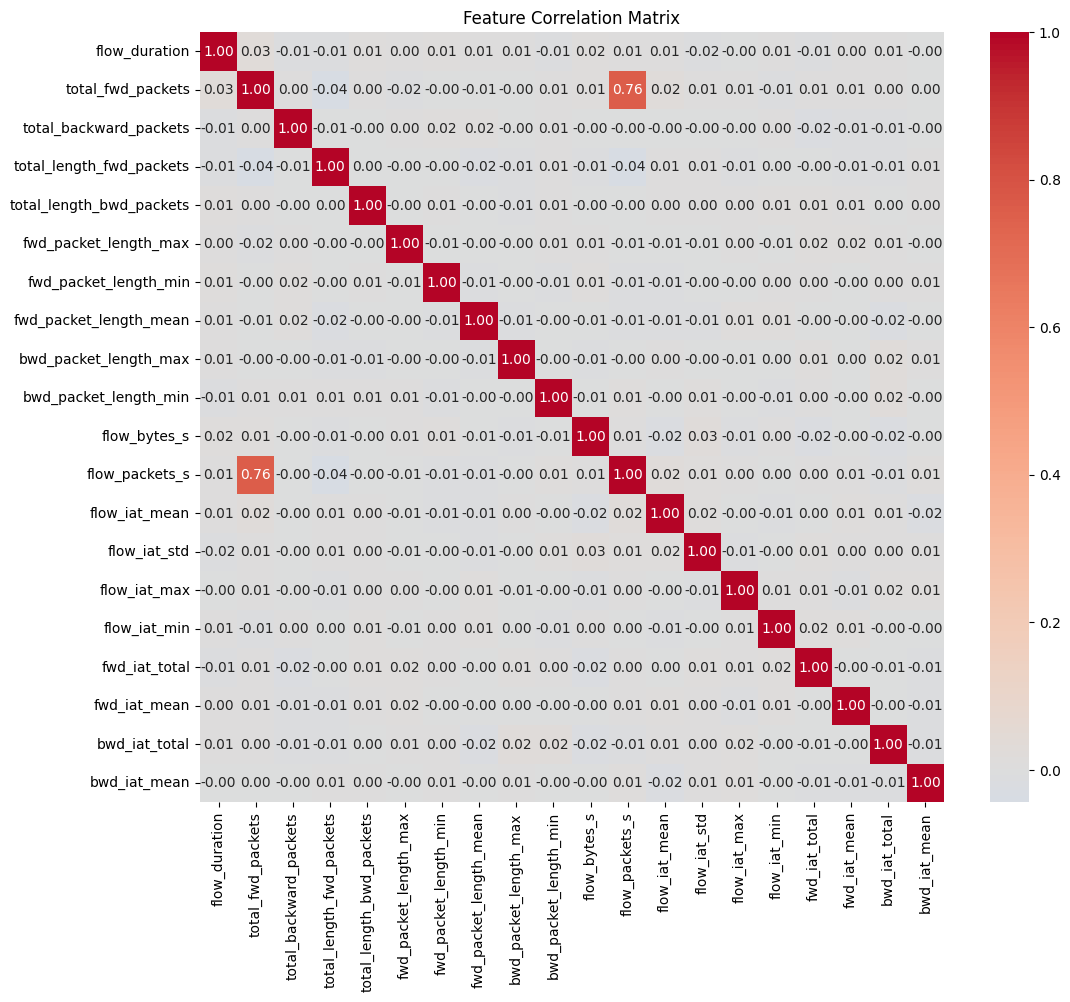

In [5]:
# Visualize label distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Feature distributions
features_to_plot = ['flow_duration', 'total_fwd_packets', 'flow_bytes_s', 'flow_packets_s']

for i, feature in enumerate(features_to_plot, 2):
    plt.subplot(2, 3, i)
    for label in df['label'].unique():
        subset = df[df['label'] == label][feature]
        plt.hist(subset, alpha=0.6, label=label, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.yscale('log')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [6]:
# Separate features and target
X = df.drop('label', axis=1)
y = df['label']

# Handle infinite and NaN values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("Label classes:", label_encoder.classes_)

Training set shape: (8000, 20)
Test set shape: (2000, 20)
Label classes: ['BENIGN' 'BruteForce' 'DDoS' 'PortScan' 'WebAttack']


In [7]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("Original training set distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for i, (cls, count) in enumerate(zip(label_encoder.classes_[unique], counts)):
    print(f"{cls}: {count}")

print("\nBalanced training set distribution:")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for i, (cls, count) in enumerate(zip(label_encoder.classes_[unique], counts)):
    print(f"{cls}: {count}")

Original training set distribution:
BENIGN: 5600
BruteForce: 560
DDoS: 800
PortScan: 640
WebAttack: 400

Balanced training set distribution:
BENIGN: 5600
BruteForce: 5600
DDoS: 5600
PortScan: 5600
WebAttack: 5600


In [8]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000)
}

# Train and evaluate models
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()

    # Train the model
    model.fit(X_train_balanced, y_train_balanced)
    trained_models[name] = model

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    training_time = time.time() - start_time

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")

    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Training Random Forest...
Accuracy: 0.9385
Precision: 0.9425
Recall: 0.9385
F1-Score: 0.9399
Training Time: 22.63 seconds

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.97      0.94      0.96      1400
  BruteForce       0.76      0.91      0.83       140
        DDoS       1.00      1.00      1.00       200
    PortScan       1.00      1.00      1.00       160
   WebAttack       0.64      0.68      0.66       100

    accuracy                           0.94      2000
   macro avg       0.87      0.91      0.89      2000
weighted avg       0.94      0.94      0.94      2000


Training Logistic Regression...
Accuracy: 0.8775
Precision: 0.9278
Recall: 0.8775
F1-Score: 0.8913
Training Time: 4.94 seconds

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.98      0.84      0.91      1400
  BruteForce       0.56      1.00      0.72       140
        DDoS       1.00      0.98      0.99      

In [ ]:
# Prepare data for LSTM (reshape for sequential input)
# LSTM expects 3D input: (samples, timesteps, features)
# We'll treat each feature as a timestep

X_train_lstm = X_train_balanced.reshape(X_train_balanced.shape[0], X_train_balanced.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Convert labels to categorical
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train_balanced)
y_test_categorical = to_categorical(y_test)

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("LSTM Model Architecture:")
lstm_model.summary()

# Train LSTM model
print("\nTraining LSTM model...")
history = lstm_model.fit(
    X_train_lstm, y_train_categorical,
    validation_data=(X_test_lstm, y_test_categorical),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate LSTM model
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_pred_classes = np.argmax(lstm_predictions, axis=1)
lstm_accuracy = accuracy_score(y_test, lstm_pred_classes)

print(f"\nLSTM Model Accuracy: {lstm_accuracy:.4f}")
print("\nLSTM Classification Report:")
print(classification_report(y_test, lstm_pred_classes, target_names=label_encoder.classes_))

LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,749 (124.02 KB)

 Trainable params: 31,749 (124.02 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.4138 - loss: 1.2965 - val_accuracy: 0.2420 - val_loss: 1.4048
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.6268 - loss: 0.8956 - val_accuracy: 0.3515 - val_loss: 0.9789
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.6793 - loss: 0.7222 - val_accuracy: 0.3820 - val_loss: 1.0660
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.7034 - loss: 0.6612 - val_accuracy: 0.4620 - val_loss: 0.8199
Epoch 5/20
204/875 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7196 - loss: 0.6078

In [10]:
# Isolation Forest for anomaly detection
# This can detect unknown/new attack patterns

# Train only on benign traffic
benign_data = X_train_scaled[y_train == 0]  # Assuming 0 is BENIGN

# Train Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_forest.fit(benign_data)

# Predict anomalies on test set
anomaly_scores = isolation_forest.decision_function(X_test_scaled)
anomaly_predictions = isolation_forest.predict(X_test_scaled)

# Convert predictions (-1 for anomaly, 1 for normal)
anomaly_binary = (anomaly_predictions == -1).astype(int)
actual_anomaly = (y_test != 0).astype(int)  # Any non-benign is anomaly

anomaly_accuracy = accuracy_score(actual_anomaly, anomaly_binary)
anomaly_precision = precision_score(actual_anomaly, anomaly_binary)
anomaly_recall = recall_score(actual_anomaly, anomaly_binary)
anomaly_f1 = f1_score(actual_anomaly, anomaly_binary)

print("Anomaly Detection Results:")
print(f"Accuracy: {anomaly_accuracy:.4f}")
print(f"Precision: {anomaly_precision:.4f}")
print(f"Recall: {anomaly_recall:.4f}")
print(f"F1-Score: {anomaly_f1:.4f}")

Anomaly Detection Results:
Accuracy: 0.7565
Precision: 0.6523
Recall: 0.4033
F1-Score: 0.4985


In [11]:
def detect_threat(flow_features, model, scaler, label_encoder, anomaly_detector=None):
    """
    Real-time threat detection function

    Args:
        flow_features: Dictionary of network flow features
        model: Trained classification model
        scaler: Fitted StandardScaler
        label_encoder: Fitted LabelEncoder
        anomaly_detector: Optional anomaly detection model

    Returns:
        Dictionary with threat prediction and confidence
    """
    # Convert features to array
    feature_array = np.array(list(flow_features.values())).reshape(1, -1)

    # Handle infinite and NaN values
    feature_array = np.nan_to_num(feature_array, nan=0.0, posinf=1e10, neginf=-1e10)

    # Scale features
    feature_array_scaled = scaler.transform(feature_array)

    # Make prediction
    prediction = model.predict(feature_array_scaled)[0]
    prediction_proba = model.predict_proba(feature_array_scaled)[0]

    # Get threat type and confidence
    threat_type = label_encoder.inverse_transform([prediction])[0]
    confidence = max(prediction_proba)

    result = {
        'threat_detected': threat_type != 'BENIGN',
        'threat_type': threat_type,
        'confidence': confidence,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    # Add anomaly detection if available
    if anomaly_detector is not None:
        anomaly_score = anomaly_detector.decision_function(feature_array_scaled)[0]
        is_anomaly = anomaly_detector.predict(feature_array_scaled)[0] == -1
        result['anomaly_detected'] = is_anomaly
        result['anomaly_score'] = anomaly_score

    return result

# Test the threat detection function
test_flow = {
    'flow_duration': 50000,
    'total_fwd_packets': 500,  # High packet count (potential DDoS)
    'total_backward_packets': 30,
    'total_length_fwd_packets': 25000,
    'total_length_bwd_packets': 1500,
    'fwd_packet_length_max': 1500,
    'fwd_packet_length_min': 50,
    'fwd_packet_length_mean': 50,
    'bwd_packet_length_max': 50,
    'bwd_packet_length_min': 50,
    'flow_bytes_s': 5000,
    'flow_packets_s': 100,  # High packet rate
    'flow_iat_mean': 10,
    'flow_iat_std': 5,
    'flow_iat_max': 50,
    'flow_iat_min': 1,
    'fwd_iat_total': 2500,
    'fwd_iat_mean': 50,
    'bwd_iat_total': 1500,
    'bwd_iat_mean': 50
}

# Use the best performing model
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_model = trained_models[best_model_name]

# Test threat detection
threat_result = detect_threat(test_flow, best_model, scaler, label_encoder, isolation_forest)

print("Threat Detection Result:")
for key, value in threat_result.items():
    print(f"{key}: {value}")

Threat Detection Result:
threat_detected: True
threat_type: DDoS
confidence: 0.86
timestamp: 2025-09-23 08:53:42
anomaly_detected: True
anomaly_score: -0.1798155511099243


In [12]:
# Save all models and preprocessing objects
import joblib

# Save the best traditional ML model
joblib.dump(best_model, 'cybersecurity_threat_detector.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(isolation_forest, 'anomaly_detector.pkl')

# Save LSTM model
lstm_model.save('lstm_threat_detector.h5')

# Save feature names
feature_names = list(X.columns)
joblib.dump(feature_names, 'feature_names.pkl')

print("Models saved successfully!")
print("Files created:")
print("- cybersecurity_threat_detector.pkl")
print("- feature_scaler.pkl")
print("- label_encoder.pkl")
print("- anomaly_detector.pkl")
print("- lstm_threat_detector.h5")
print("- feature_names.pkl")

Models saved successfully!
Files created:
- cybersecurity_threat_detector.pkl
- feature_scaler.pkl
- label_encoder.pkl
- anomaly_detector.pkl
- lstm_threat_detector.h5
- feature_names.pkl
